### Assessment 2 : Lanthanides

# Part 1
Analyse the data with Principal Component Analysis (PCA) and k-means clustering decide how to deal with missing data and identify and explain any clusters observed.

In [42]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import IncrementalPCA

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

## Filling in the NaN
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [43]:
# Read in the data, split the numerical data from the element names
df_all = pd.read_csv("Lanthanides.csv")
elements = df_all["Element"]
df = df_all.iloc[:,1:]

In [44]:
df.describe()

,Ma,d/(g/cm3),ra/pm,χ,I1/(kJ/mol),I2/(kJ/mol),I3/(kJ/mol),Tm/K,Tb/K,ΔfusH/(kJ/mol),ΔvapH/(kJ/mol),ΔatmH/(kJ/mol),S/(J/mol K),Cp/(J/g K),σm/(MN/m),ρ/(µΩ cm),λ/(W cm-1 K-1),ΔfG/(kJ/mol)
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,16.000000,17.000000,17.000000,17.000000,16.000000,17.000000,17.000000,17.000000
mean,145.476765,7.227059,180.235294,1.192941,565.476471,1125.276471,2154.500000,1495.705882,3050.058824,11.131765,279.843750,328.311765,65.947059,0.208059,659.125000,76.582353,0.156824,-323.647059
std,32.698112,1.796075,8.947971,0.068990,34.969425,83.719879,165.167718,303.925518,732.456950,4.644774,90.952449,90.447076,12.336841,0.093100,190.418793,24.363272,0.063654,32.359197
min,44.956000,2.990000,164.000000,1.100000,523.100000,1017.900000,1850.300000,1068.000000,1467.000000,5.460000,128.900000,152.000000,34.600000,0.144000,264.000000,25.000000,0.105000,-405.000000
25%,140.908000,6.770000,176.000000,1.130000,535.900000,1067.100000,2022.200000,1208.000000,2840.000000,7.660000,220.250000,291.000000,59.900000,0.169000,645.250000,61.500000,0.125000,-331.000000
50%,151.960000,7.260000,180.000000,1.200000,564.600000,1126.000000,2151.600000,1586.000000,3300.000000,10.000000,284.900000,348.000000,71.600000,0.184000,674.500000,74.400000,0.145000,-321.000000
75%,164.930000,8.550000,182.000000,1.230000,592.500000,1166.500000,2257.700000,1795.000000,3610.000000,14.100000,356.775000,398.000000,73.200000,0.190000,709.750000,90.000000,0.165000,-301.000000
max,174.967000,9.840000,204.000000,1.360000,631.000000,1341.100000,2416.900000,1936.000000,3790.000000,19.900000,400.000000,431.000000,77.800000,0.544000,954.000000,131.000000,0.385000,-284.000000


Here we can see that the columns are very much on different orders of magnitude, therefore they should be standardised when using distance based analysis.

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ma              17 non-null     float64
 1   d/(g/cm3)       17 non-null     float64
 2   ra/pm           17 non-null     int64  
 3   χ               17 non-null     float64
 4   I1/(kJ/mol)     17 non-null     float64
 5   I2/(kJ/mol)     17 non-null     float64
 6   I3/(kJ/mol)     17 non-null     float64
 7   Tm/K            17 non-null     int64  
 8   Tb/K            17 non-null     int64  
 9   ΔfusH/(kJ/mol)  17 non-null     float64
 10  ΔvapH/(kJ/mol)  16 non-null     float64
 11  ΔatmH/(kJ/mol)  17 non-null     float64
 12  S/(J/mol K)     17 non-null     float64
 13  Cp/(J/g K)      17 non-null     float64
 14  σm/(MN/m)       16 non-null     float64
 15  ρ/(µΩ cm)       17 non-null     float64
 16  λ/(W cm-1 K-1)  17 non-null     float64
 17  ΔfG/(kJ/mol)    17 non-null     int64

Using the .info() function as well as looking at the data set, one can see that the colunms "ΔvapH/(kJ/mol)" and "σm/(MN/m)" both contain 1 NaN value.

Since our dataset is small with unique data to each element, it is much better to infer these missing values rather than disregard the whole row.

There are different statistical techniques that can be used to estimate the missing values.
The methods that we will explore include :
- Mean and Median Imputation, however this can lead to a biased estimate if the data has a skewed distribution.
- Simple Linear Regression Imputation : Replacing missing values with predictions generated by a regression model.
- Multiple Linear Regression Imputation : Creating multiple imputed datasets and then analyzes them together to produce a more robust and accurate estimate of the missing values.
- K Means Clustering : Cluster the data into groups using the k-means algorithm and then to replace the missing values in each group with the mean value of the non-missing values within the group.

#### Replacing the NaNs

Method 1 : Inputing metrics values

- This could mean using the mean
    - The mean has a very interesting property whereby it doesn't change if you add more mean values to your data.
- The median
    - Splits the values in 2 halves and takes the middle value no skewed by new values as much as mean.

In [46]:
# Creating the mean and median dataframes
df_mean = df.copy()
df_median = df.copy()

## Replacing all NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
df_mean_imputed = imputer.fit_transform(df_mean)

## Replacing all NaN values with the median of the column
imputer = SimpleImputer(strategy='median')
df_median_imputed = imputer.fit_transform(df_median)


df_mean_imputed = pd.DataFrame(df_mean_imputed)
df_mean_imputed.columns = df.columns

df_median_imputed = pd.DataFrame(df_median_imputed)
df_median_imputed.columns = df.columns


value1 = df_mean_imputed["ΔvapH/(kJ/mol)"][6]
value2 = df_mean_imputed["σm/(MN/m)"][14] 
print("For Mean Imputation: ")
print(f"The missing value for ΔvapH/(kJ/mol) is {value1}.") 
print(f"The missing value for σm/(MN/m) is {value2}.")

print("For Median Imputation: ")
value1 = df_median_imputed["ΔvapH/(kJ/mol)"][6]
value2 = df_median_imputed["σm/(MN/m)"][14] 
print(f"The missing value for ΔvapH/(kJ/mol) is {value1}.") 
print(f"The missing value for σm/(MN/m) is {value2}.")


For Mean Imputation: 
The missing value for ΔvapH/(kJ/mol) is 279.84375.
The missing value for σm/(MN/m) is 659.125.
For Median Imputation: 
The missing value for ΔvapH/(kJ/mol) is 284.9.
The missing value for σm/(MN/m) is 674.5.


Method 2 : Simple Linear Regression Imputation

In [47]:
# Create the dataframe
df_sing_reg = df.copy()

Train a linear model to find the seperate values. Will train a 2 models. One to predict ΔvapH/(kJ/mol) and one for σm/(MN/m).

- A quick way would be to find a column with a high correlation to the one we want to find a value for. A simple linear regression model could then be trained off the two column and a suitable imputable value can be calculated. 

In [48]:
df.corr().head()

,Ma,d/(g/cm3),ra/pm,χ,I1/(kJ/mol),I2/(kJ/mol),I3/(kJ/mol),Tm/K,Tb/K,ΔfusH/(kJ/mol),ΔvapH/(kJ/mol),ΔatmH/(kJ/mol),S/(J/mol K),Cp/(J/g K),σm/(MN/m),ρ/(µΩ cm),λ/(W cm-1 K-1),ΔfG/(kJ/mol)
Ma,1.000000,0.868690,0.336646,-0.317519,-0.397909,-0.072709,-0.018879,-0.120679,-0.256316,0.129541,-0.364130,-0.364868,0.719466,-0.929526,-0.505585,0.226164,0.115689,0.230302
d/(g/cm3),0.868690,1.000000,-0.144351,0.040275,-0.272558,0.144127,-0.126514,0.297898,-0.010042,0.440018,-0.157782,-0.107784,0.564918,-0.736813,-0.091693,0.288231,-0.073828,0.338545
ra/pm,0.336646,-0.144351,1.000000,-0.662319,-0.225569,-0.338621,0.202693,-0.648802,-0.481473,-0.447482,-0.449320,-0.525168,0.331390,-0.446943,-0.784427,-0.065404,0.331468,-0.289548
χ,-0.317519,0.040275,-0.662319,1.000000,0.703287,0.811946,0.330972,0.838060,-0.048030,0.751272,-0.001046,0.075446,-0.547324,0.564260,0.502571,-0.124647,0.124658,0.571748
I1/(kJ/mol),-0.397909,-0.272558,-0.225569,0.703287,1.000000,0.496997,0.396354,0.511619,-0.285638,0.403203,-0.132607,-0.148070,-0.439499,0.548659,0.101693,-0.087737,0.316040,0.261853


For ΔvapH/(kJ/mol):

In [49]:
df.corr()["ΔvapH/(kJ/mol)"].nlargest(2)

ΔvapH/(kJ/mol)    1.00000
ΔatmH/(kJ/mol)    0.98582
Name: ΔvapH/(kJ/mol), dtype: float64

In [50]:
df[["ΔvapH/(kJ/mol)","ΔatmH/(kJ/mol)"]].head()

,ΔvapH/(kJ/mol),ΔatmH/(kJ/mol)
0,310.0,377.8
1,393.3,424.7
2,400.0,431.0
3,398.0,423.0
4,296.8,356.0


This shows that the second largest correlation to ΔvapH/(kJ/mol) is ΔatmH/(kJ/mol), which has a very very high correlation of 0.98582. These two variables have a very strong linear relationship and therefore a simple linear regression model should accurately predict the missing value for ΔvapH/(kJ/mol).

In [51]:
#Create dependent and independent variables
y = df["ΔvapH/(kJ/mol)"].drop(6).values # vapH
X = df["ΔatmH/(kJ/mol)"].drop(6).values.reshape(-1,1) # atm
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
predX=[[df["ΔatmH/(kJ/mol)"].loc[6]]]

reg = LinearRegression().fit(X_train,y_train)

y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)

prediction = reg.predict(predX)[0]

print(f"The missing value for ΔvapH/(kJ/mol) is {prediction}, R2 score of {r2}")

# Adding the value to the dataframe
df_sing_reg.loc[6,"ΔvapH/(kJ/mol)"] = prediction


The missing value for ΔvapH/(kJ/mol) is 299.5163215288995, R2 score of 0.9660587946710816


The same can be done for σm/(MN/m).

In [52]:
df.corr()["σm/(MN/m)"].nlargest(2)

σm/(MN/m)         1.000000
ΔatmH/(kJ/mol)    0.873065
Name: σm/(MN/m), dtype: float64

For σm/(MN/m)

It happends to have the same column as its biggest correlation, the correlation is still quite strong however not to the same degree as it was before.

In [53]:
#Create dependent and independent variables
y = df["σm/(MN/m)"].drop(14).values # σm/(MN/m)
X = df["ΔatmH/(kJ/mol)"].drop(14).values.reshape(-1,1) # atm
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
predX=[[df["ΔatmH/(kJ/mol)"].loc[14]]]

reg = LinearRegression().fit(X_train,y_train)

y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)

prediction = reg.predict(predX)[0]

print(f"The missing value for σm/(MN/m) is {prediction}, R2 score of {r2}")

#Addin the value to the dataset
df_sing_reg.loc[14,"σm/(MN/m)"] = prediction


The missing value for σm/(MN/m) is 461.62459171457436, R2 score of 0.7020213363338601


The r2 score of σm/(MN/m) is much lower than ΔvapH/(kJ/mol as expected due to the lower level of correlation it had with the independent varaible. The r2 score is quite low and has a value that is way off the median and mode predictions.

Using this linear regression works if there is a highly correlated column. This therefore only works for the ΔvapH/(kJ/mol column which gets a good result. Another method should be used for both or at least  σm/(MN/m). 

Method 3 : Multiple linear regression

For ΔvapH/(kJ/mol):

In [54]:
df_mult_reg = df.copy()

# Dependent and independent varaibles # want to drop the row which contains a NaN
df_mult_reg_1 = df_mult_reg.drop(14,axis=0)

y = df_mult_reg_1["ΔvapH/(kJ/mol)"].drop(6,axis=0).values
X = df_mult_reg_1.drop("ΔvapH/(kJ/mol)",axis=1).drop(6,axis=0).values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=43)
predX = [df_mult_reg_1.iloc[6].dropna().values]

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)

prediction1 = reg.predict(predX)[0]

print(f"The missing value for ΔvapH/(kJ/mol) is {prediction1}, R2 score of {r2}") #R2 score is significantly changed by random state

The missing value for ΔvapH/(kJ/mol) is 284.2107378388258, R2 score of 0.9672320445359208


Doing test and train on such a small data set means that the R2 widely changes with the random state. It is therefore important to try a range of random states in order to get an idea for the power of the model.

For σm/(MN/m) :

In [55]:
df_mult_reg_2 = df_mult_reg.drop(6,axis=0)


y = df_mult_reg_2["σm/(MN/m)"].drop(14,axis=0).values
X = df_mult_reg_2.drop("σm/(MN/m)",axis=1).drop(14,axis=0)#.values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
predX = [df_mult_reg_2.iloc[13].dropna().values]

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)

prediction2 = reg.predict(predX)[0]

print(f"The missing value for σm/(MN/m) is {prediction2}, R2 score of {r2}.") #R2 score is significantly changed by random state


The missing value for σm/(MN/m) is 533.8391324813008, R2 score of 0.9209156427520728.


Multiple linear regression gives a good r2 score for both columns, this data is reliable enoguh to be used to fill in the missing values in the dataset.

These values are then imputed into the mult_reg dataframe

In [56]:
df_mult_reg.loc[14,"σm/(MN/m)"] = prediction2
df_mult_reg.loc[6,"ΔvapH/(kJ/mol)"] = prediction2

Method 4 : Using k-nearest neighbors
- Find the closest k samples from dataset to the sample with NaN value, and impute it with it the mean value of these samples. The challenge his is deciding on the number of neighbours for the model.

In [57]:
df_knn = df.copy()

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(df_knn)
df_knn = imputer.transform(df_knn)

df_knn = pd.DataFrame(df_knn)
df_knn.columns = df.columns
df_knn


value1 = df_knn["ΔvapH/(kJ/mol)"][6]
value2 =df_knn["σm/(MN/m)"][14] 
print(f"The missing value for ΔvapH/(kJ/mol) is {value1}.") 
print(f"The missing value for σm/(MN/m) is {value2}.") 


The missing value for ΔvapH/(kJ/mol) is 304.21999999999997.
The missing value for σm/(MN/m) is 589.4.


The paper uses 5 neighbours, so that is what was done, since we are already happy with the multiple linear regression values it is not necessary to explore the knn method too deeply. 

### Principal Component Analysis

Principal Component Analysis (PCA) is a common method used for dimensionality reduction in data analysis. It involves transforming a set of related variables into a new set of unrelated variables called principal components. The main aim of PCA is to capture the maximum variation in the original data while reducing the number of variables used in the analysis.

The first principal component represents a linear combination of the original variables that explains the most variability in the data, while the second principal component is defined as a linear combination of the remaining variables that explains the most variability, but is also uncorrelated with the first principal component. Additional principal components follow a similar pattern.

In [58]:
df.corr().head()

,Ma,d/(g/cm3),ra/pm,χ,I1/(kJ/mol),I2/(kJ/mol),I3/(kJ/mol),Tm/K,Tb/K,ΔfusH/(kJ/mol),ΔvapH/(kJ/mol),ΔatmH/(kJ/mol),S/(J/mol K),Cp/(J/g K),σm/(MN/m),ρ/(µΩ cm),λ/(W cm-1 K-1),ΔfG/(kJ/mol)
Ma,1.000000,0.868690,0.336646,-0.317519,-0.397909,-0.072709,-0.018879,-0.120679,-0.256316,0.129541,-0.364130,-0.364868,0.719466,-0.929526,-0.505585,0.226164,0.115689,0.230302
d/(g/cm3),0.868690,1.000000,-0.144351,0.040275,-0.272558,0.144127,-0.126514,0.297898,-0.010042,0.440018,-0.157782,-0.107784,0.564918,-0.736813,-0.091693,0.288231,-0.073828,0.338545
ra/pm,0.336646,-0.144351,1.000000,-0.662319,-0.225569,-0.338621,0.202693,-0.648802,-0.481473,-0.447482,-0.449320,-0.525168,0.331390,-0.446943,-0.784427,-0.065404,0.331468,-0.289548
χ,-0.317519,0.040275,-0.662319,1.000000,0.703287,0.811946,0.330972,0.838060,-0.048030,0.751272,-0.001046,0.075446,-0.547324,0.564260,0.502571,-0.124647,0.124658,0.571748
I1/(kJ/mol),-0.397909,-0.272558,-0.225569,0.703287,1.000000,0.496997,0.396354,0.511619,-0.285638,0.403203,-0.132607,-0.148070,-0.439499,0.548659,0.101693,-0.087737,0.316040,0.261853


The correlation data confirms that the Lanthanides properties are related to eachother and therefore can be reduced.

The imputed data that will be used is from the multiple linear regression imputatation.

In [59]:
df = df_mult_reg

Standardization is often used in PCA because it ensures that each variable contributes equally to the analysis, regardless of its scale or units. In PCA, variables with larger scales and variances tend to dominate over those with smaller scales and variances.

In [60]:
# Standardize the data to have a mean of ~0 and a variance of 1
df_ss = StandardScaler().fit_transform(df)

# Create a PCA instance: pca
pca = PCA(n_components=17)

# do the PCA on the x_std matrix, and save the outputs as principalComponents
principalComponents = pca.fit_transform(df_ss)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0.5, 1.0, 'Plot of the PCA data for the first two indexes')

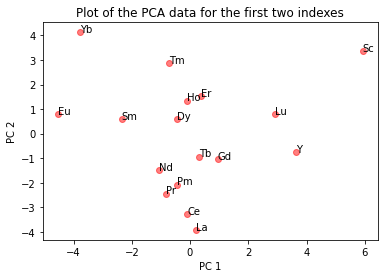

In [61]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.5, color='red')
for i, label in enumerate(elements):
  plt.annotate(label, (PCA_components[0][i], PCA_components[1][i]))

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title("Plot of the PCA data for the first two indexes")

The initial scatter plot of the PCA data in the first two indexes shows no clear pattern or clustering within the Lanthanides. The group 3 elements Sc and Y are on the outsides of the data as well as La which is what would be expected as we would expect the lanthanides to be very similar together due to their similar properties and the group 3 elements to be slightly seperated from them. Using k means clustering, it is possible to try to classify these data points in order to gather insights from the data.

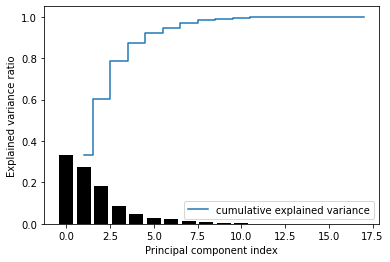

In [62]:
# Plot the explained variances
features = range(pca.n_components_)

# calculate cumulative sum of explained variances
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.step(range(1,18), cum_var_exp, where='mid',
label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

#print(pca.explained_variance_ratio_)

This plot shows the eigenvalues of the correaltion maxtrix ordered from largerst to smallest and shows the proportion and cumulative proportion for each component. The first component explains 34.18% of the total varaicnes and the second componenent explains 27.49%, therefore a two componenent model only accounts for 61.67% of the total variance. A 3 component model would account of 79.93 of the total varaince. The larger the index the more noise is added, therefore sticking to 3 components and lower for this small dataset is enough to capture the model.

Since the third component is still quite significant, it is useful to plot a 3D graph

Text(0.5, 0, 'PC 3')

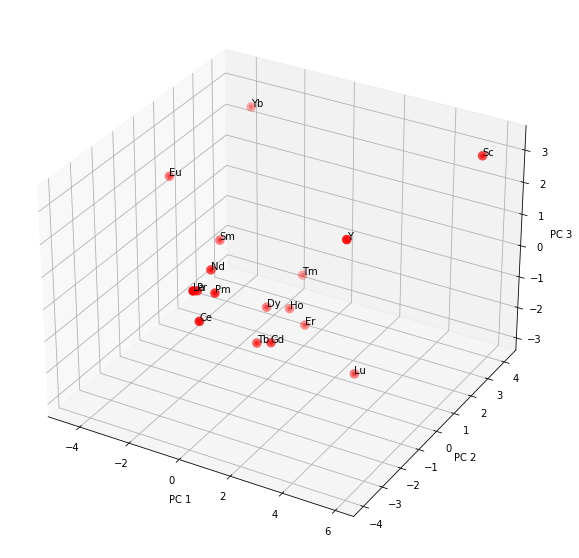

In [63]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

#plt.scatter(PCA_components[0], PCA_components[1], PCA_components[2],alpha=1, c="black",marker='o', linewidths=5,cmap='Set1',vmax=10)
ax.scatter3D(PCA_components[0], PCA_components[1], PCA_components[2],linewidths=5, color='red')

for i, label in enumerate(elements):
    ax.text(PCA_components[0][i], PCA_components[1][i], PCA_components[2][i], label)# size=20, zorder=1, color='k') 
    # ax.plot((PCA_components[0][i], PCA_components[1][i],PCA_components[2][i]), (PCA_components[0][i], PCA_components[1][i],-3))
    # ax.scatter(PCA_components[0][i], PCA_components[1][i],-3)
    

plt.xlabel('PC 1')
plt.ylabel('PC 2')
ax.set_zlabel('PC 3')

K-means clustering is often used on data that has been pre-processed using principal component analysis (PCA) because PCA can reduce the dimensionality of the data and remove highly correlated variables, making it easier for K-means clustering to identify clusters based on similarity in the remaining variables. When K-means clustering is applied to a dataset that has been pre-processed using PCA, the clustering algorithm works with the reduced set of principal components, rather than the original high-dimensional data. This can make the clustering process faster and more accurate, since the PCA transformation has removed highly correlated variables and reduced the dimensionality of the data.

The number of clusters in K-means clustering can have a significant impact on the results of the algorithm. If the number of clusters is too small, the resulting clusters may be too general and not capture the underlying structure in the data. If the number of clusters is too large, the algorithm may overfit the data and create clusters that are too specific or noisy. However this variablilty allows us to investigate at different detailed scales and therefore we will want to use a number of different cluster values. Therefore a function to plot a cluster plot with n clusters was made.

In [64]:
def cluster_plots(c_list, index1=0, index2=1):

    fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,15))
    axes = axes.flatten()
    ind = 0
    

    for n in c_list:

        kmeans = KMeans(n_clusters=n)
        kmeans.fit(PCA_components.iloc[:,:])
        
        labels = kmeans.predict(PCA_components.iloc[:,:])

        axes[ind].scatter(PCA_components[index1], PCA_components[index2], alpha=1, c=labels, cmap="Set1")

        for i, label in enumerate(elements):
            axes[ind].annotate(label, (PCA_components[index1][i], PCA_components[index2][i]))

        axes[ind].set_title(f"{c_list[ind]} Clusters")
        axes[ind].set_xlabel(f'PC {index1}')
        axes[ind].set_ylabel(f'PC {index2}')
        axes[ind].axis('equal')

        ind+=1

    fig.tight_layout()  

#Single Plot
def cluster_plot(n, index1=0, index2=1):

    fig, ax = plt.subplots(figsize=(7,7))

    kmeans = KMeans(n_clusters=n)
    kmeans.fit(PCA_components.iloc[:,:])
    
    labels = kmeans.predict(PCA_components.iloc[:,:])

    ax.scatter(PCA_components[index1], PCA_components[index2], alpha=1, c=labels, cmap="Set1")

    for i, label in enumerate(elements):
        ax.annotate(label, (PCA_components[index1][i], PCA_components[index2][i]))

    ax.set_title(f"{n} Clusters")
    ax.set_xlabel(f'PC {index1}')
    ax.set_ylabel(f'PC {index2}')
    ax.axis('equal')

    fig.tight_layout()  

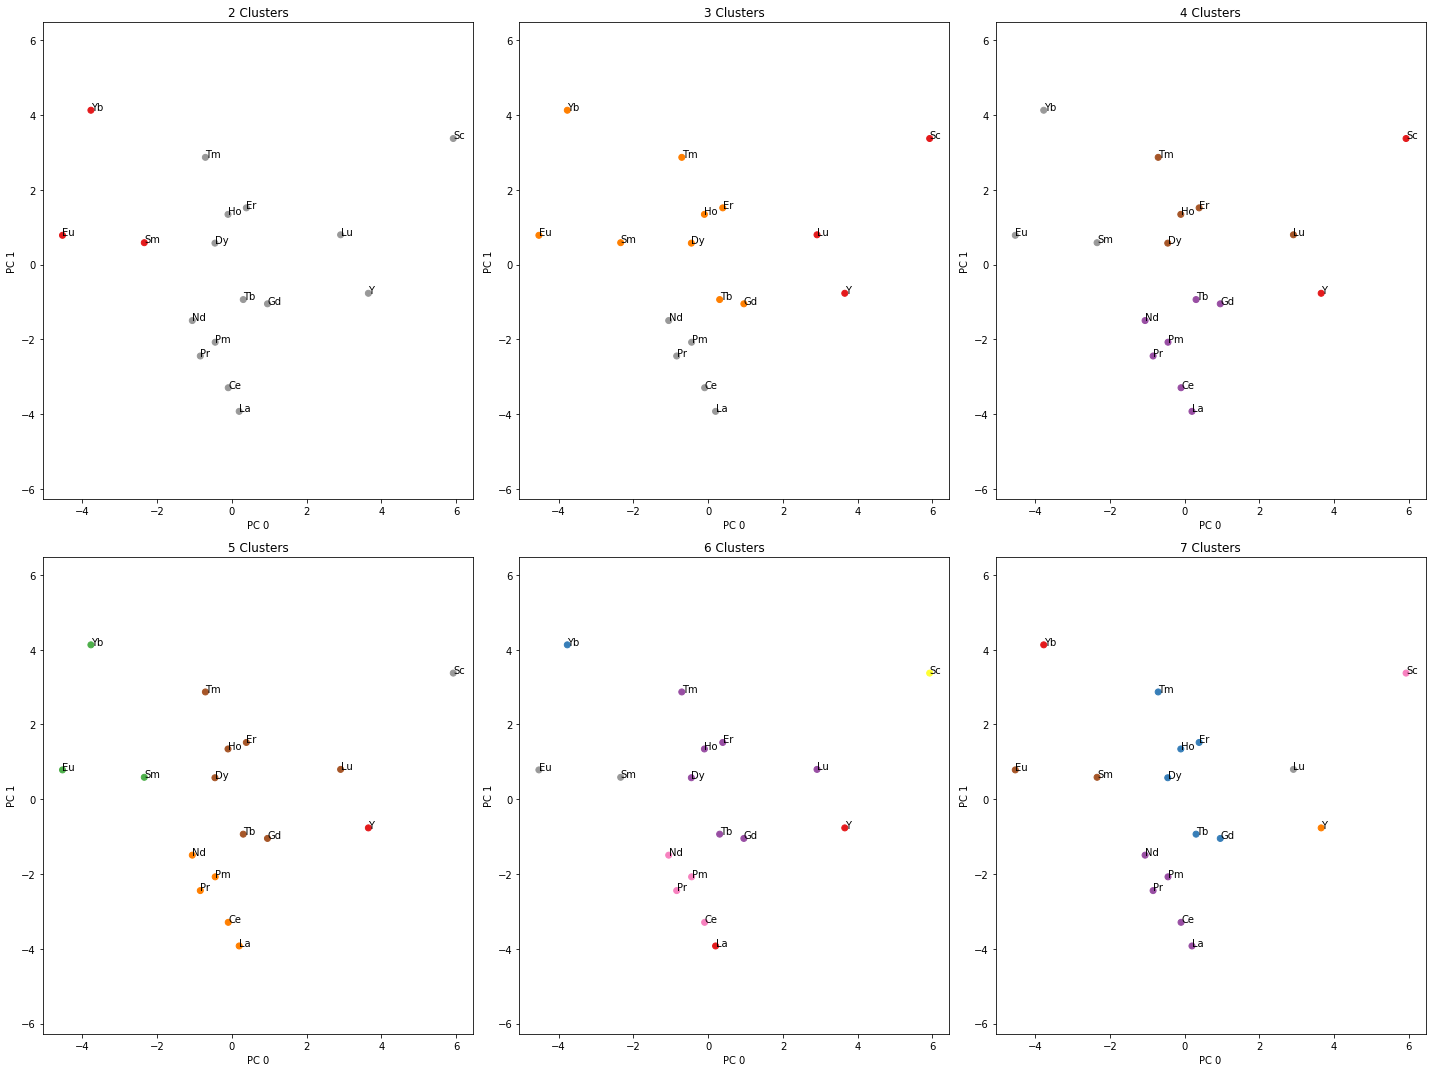

In [65]:
#Plotting the clusters
n_list = [2,3,4,5,6,7]
cluster_plots(n_list,0,1)

Without the scientific context, it is possible to spot some clustering patterns within the plots. For example it is clear that Sc and Y are somehow related and also different to the rest of the plots shown in the plot with 2 clusters. As the clustering gets less general, the rest of the points split up into two suggesting a detail within the cluster that is splitting them up. For each of these plots a scientific discussion is done below.

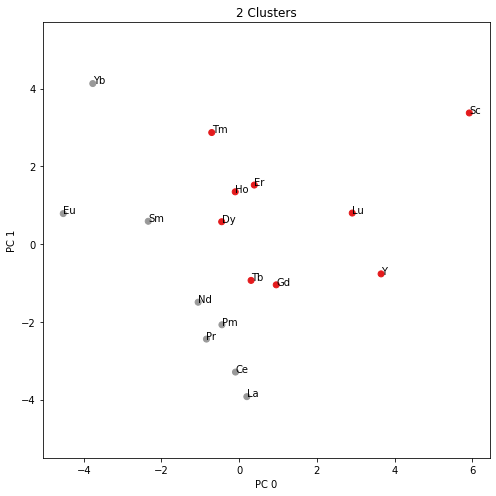

In [66]:
cluster_plot(2)

Using two clusters shows clear separations and natural groupings. This is as general as clustering can get and therefore expect generalised clusters to form. In the case of this dataset, we know that there are two group 3 elements and then there is the identiy of Lanthanum which is unclear whether it belongs in group 3 or whether it belongs with the Lanthanides and then there is the Lantanides. For a general 2 clusterering algorithm, we would expect to see a difference between the group 3 elements and the lanthanides, however it is unsure as to where Lanthanum should be. This difference would be expected as although the group 3 properties are analagous to some of the Lanthanides, the overall difference in properties should be significant enough to seperate them from the Lantahnides. It can be helpful to look at a periodic table to see how far away the elements are and therefore just how relatively different they are to the differences between the Lanthanides.

As seen in the graph, the two group 3 elements Yytrium and Scandium are clustered separetly to the other elements. There is a table in the paper that was provided which shows all the electronic configurations. The noble gas configuration base for Sc and Y are Ar and Kr respectively, unlike Lanthium and the Lanthanides which all have a Xe base. The difference also comes from the fact that Sc and Y are the only two to not have 6s^2 orbitals. Therefore having significantly different physical properties relative to the difference in physical properties within the Lanthanides.

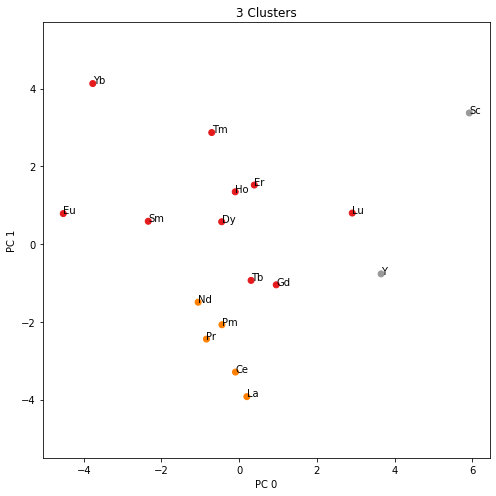

In [67]:
cluster_plot(3)

When splitting into 3 clusters, once again the group 3 elements Y and Sc are in a seperate cluster, but now the main cluster has been divided in two. One may notice that the clusters are split up into La Ce Pr Pm Nd and then the rest is the cluster spltting them up into two "weight catergories", the elements mentioned are refered to as the "light Lanthanides" and the remaining elements are the "heavy". The cluster known as the light lanthanides should include Sm in that category in order to line up with the results in the paper, however the method in which the Nan values were filled differ which will differ the PCA results for the elements ever so slightly as well as the fact that Sm is right on the tipping point and could therefore fall easily into either category. 

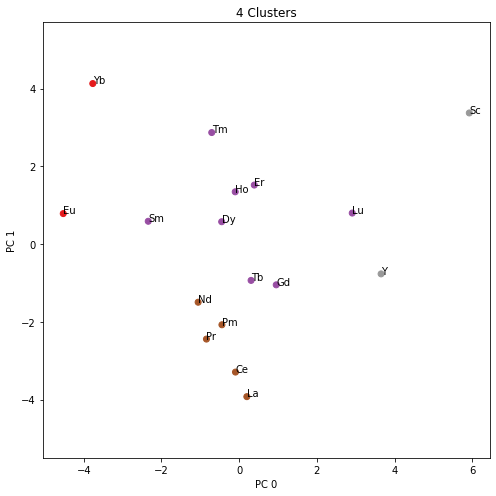

In [68]:
cluster_plot(4)

The 4 cluster point is relatively the same as before, showing off the group 3 elements, and the splitting of the light and heavy Lanthanides. However with an extra cluster Eu, Yb and Sm are now in a group of their own. This can be explained by the fact that these elements are particularly stable electron configurations reletive to the others and therefore many of their properties deviate from the rest of the lanthanides. Eu and Yb both represent the same "group" in the Lanthanides with full outer orbitals.

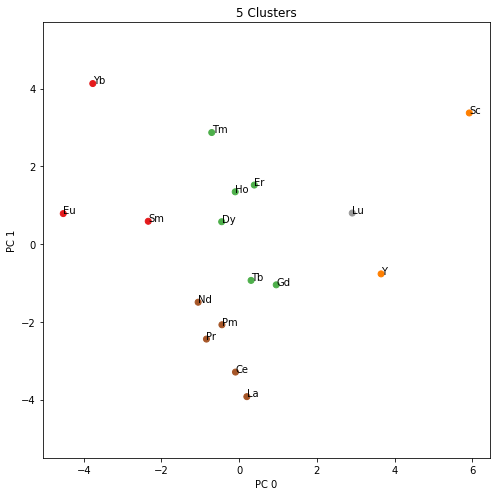

In [69]:
cluster_plot(5)

5 Clusters uniquely identifies Lu as different from the other Lanthanides. By having an electron configuration with one electron in the d subshell with the f subshell completely occupied unlike the other lanthanides as well as being the heaaviest element with greatest atomic number which brings it further away from the rest of the Lanthanides in terms of the PCA distance. The analysis almost supports Lu being assigned to the third group as an analogue to Y, as seen in the scatter Lu is split apart from the other Lanthanides as well as being almost just as close to the group 3 elements as it is to the Lanthanides in the cluster. This shows how clustering can be used to identifiy analogues and categorise the complicated elements.

In conclusion, starting with a partically empty dataset the missing data was imputed using a varierty of methods such as linear regressions. Using a multiple linear regression a complete dataframe was created for the use of exploring the clusters within the data in order to identify some scientific relations. After standardising the data a PCA fit was used in order to bring the number of dimensions down to a managable level. The PCA data was clustered using k means with a range of n_cluster levels. The clusters showed a more detailed look at the data the more clusters were incorporated. The most basic two clusters identified Y and Sc as being different from the rest of the elements, this was easily explained through the paper and scientific context as these elements are very different in terms of their atomic number/ size as well as their electronic configuration where as all the other elements were relatively similar. Three clusters split the remaining elements into two groups, this was explained by the different "weights" of the Lanthanides as briefly discussed in the paper. Going up to four clusters it was able to identify the more stable elements as being different from the general Lanthanides, the stability was explained. As the amount of clusters becomes larger, the more the variances of the data effects the output, at a point when the amount of clusters starts to get close to the amount of datapoints the method isn't very useful. At 5 clusters Lu is identified by itself suggesting that the Lu is different to the rest of the Lanthanides, the position of Lu in the two dimension PCA plot shows its proximity to the group 3 elements, especially Y. This creates the argument that Lu is an analogue of Y and could almost be considred a group 3 element itself.

# Part 2
- The 1st ionisation energy is defined as the energy required to remove one electron from the outer shell of an atom (labelled as I1 in your data table).
- Considering the change in atomic nucleus and electronic configuration, how would you expect the 1st ionisation energy to change on moving across the f-block? 
- Hence, considering also the results of your PCA analysis, compute posterior distribution(s) for the average 1st ionisation energy for the Lanthanides. 
- You should justify your choice of prior and likelihood distributions and sampling of data points.

In [70]:
first_ions = pd.merge(elements,df["I1/(kJ/mol)"], right_index=True,left_index=True)
first_ions

,Element,I1/(kJ/mol)
0,Sc,631.0
1,Y,616.0
2,La,538.1
3,Ce,527.4
4,Pr,523.1
5,Nd,529.6
6,Pm,535.9
7,Sm,543.3
8,Eu,546.7
9,Gd,592.5



Since we are only interested in the f-block elements, Sc, Y and La will be removed.

On moving across the f-block lanthanides, the first ionization energy is generally expected to increase. This is because the lanthanides have their outermost electrons in the f orbitals, which are shielded by the filled 5s and 5p orbitals of the preceding elements.

The f orbitals are not very effective at shielding the nuclear charge, so the effective nuclear charge experienced by the outermost electrons increases as you move across the lanthanides. This results in a stronger attraction between the electrons and the nucleus, making it more difficult to remove the outermost electron, which in turn leads to a higher first ionization energy.

Overall, the first ionization energy of the lanthanides is expected to increase as you move across the f-block, with some exceptions due to the unique electron configurations of some elements.

In [71]:
first_ions = first_ions.iloc[2:]
first_ions

,Element,I1/(kJ/mol)
2,La,538.1
3,Ce,527.4
4,Pr,523.1
5,Nd,529.6
6,Pm,535.9
7,Sm,543.3
8,Eu,546.7
9,Gd,592.5
10,Tb,564.6
11,Dy,571.9


Text(0, 0.5, '1st Ionisatoin Energy')

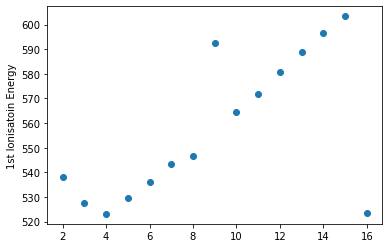

In [72]:
plt.scatter(first_ions.index, first_ions["I1/(kJ/mol)"])
plt.ylabel("1st Ionisatoin Energy")


The data shows that, in general, the first ionization energy of the lanthanides increases as you move from left to right across the series, as expected.

Overall, the first ionization energy data for the lanthanides supports the trend of increasing first ionization energy across the series, with some exceptions due to the unique electronic configurations of certain elements.

The obvious exceptions come at Ce being slightly larger than it should be in order to fit the trend, however this diveregence is not nearly as significant than the values at Lu and Gd.
Ld and Gd both have a 5d1 rahter than a 5d0 orbital.

In [73]:
first_ions.describe()

,I1/(kJ/mol)
count,15.000000
mean,557.740000
std,29.059073
min,523.100000
25%,532.750000
50%,546.700000
75%,584.700000
max,603.400000


To compute a posterior distribution for the average 1st ionisation energy for the Lanthanides, we can use a Bayesian approach. We need to specify a prior distribution for the parameter of interest, i.e., the average 1st ionisation energy, and a likelihood function that describes how the observed data points were generated.

For the prior distribution, we can use a normal distribution with mean and variance based on our knowledge of the Lanthanides. For example, we may use the mean and standard deviation of the 1st ionisation energies of the Lanthanides in the data table as our prior mean and standard deviation, respectively.

In [74]:
prior_dist = first_ions.mean()

C:\Users\georg\AppData\Local\Temp/ipykernel_5884/799684153.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  prior_dist = first_ions.mean()


For the likelihood function, we need to assume a distribution for the observed data points. Since the 1st ionisation energy is a continuous variable, we can use a normal distribution to model the data. The mean of the normal distribution is the parameter of interest, i.e., the average 1st ionisation energy for the Lanthanides, and the variance is the variance of the observed data points.

In [75]:

mean = first_ions["I1/(kJ/mol)"].mean()
std = first_ions["I1/(kJ/mol)"].std()
size = (1,1)

likeli = np.random.normal(mean,std,size)
print(std)


29.059072839402752


To sample data points, we can use a subset of the 1st ionisation energies for the Lanthanides in the data table. We can then use a Markov Chain Monte Carlo (MCMC) algorithm to sample from the posterior distribution of the average 1st ionisation energy given the prior and likelihood functions

In [86]:

#defining the beta function and gaussian which have been taken from workshop 14
import math

def calculate_beta(x, a, b): 

    A1 = x**(a-1)

    A2 = (1-x)**(b-1)

    A3 = math.gamma(a)*math.gamma(b)/math.gamma(a+b)

    return A1*A2/A3


def compute_gaussian(x,mean,sd):

    A1 = sd*np.sqrt(2*np.pi)

    A2 = 0.5*((x-mean)/(sd))**2

    return (1/A1)*np.exp(-A2)

Since we are looking only at the Lanthanides, the Sc and Y points should be removed from the data set.

Text(0.5, 1.0, 'First ionistation energy of the elements')

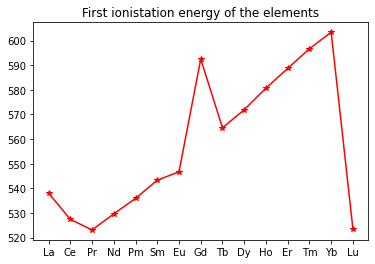

In [77]:
first_ions = df_all['I1/(kJ/mol)'][2:]

x1 = round(np.mean(df_all['I1/(kJ/mol)']),1)

fig, ax = plt.subplots()
ax.plot(elements[2:],first_ions,'*-',color="red");
ax.set_title("First ionistation energy of the elements")

From this plot of all the ionisation in order of element weight, you can see that there is a sort of disribution. Where on average the energies are increaseing and then at the end it drops. This can be almost modelled by a Beta distribution where the mean is shifted to the right, this will also encompass the large drop at the end. Therefore a likelihood dist will be created with the beta function between the min and max energy levels.

Unnormalised areas = 1


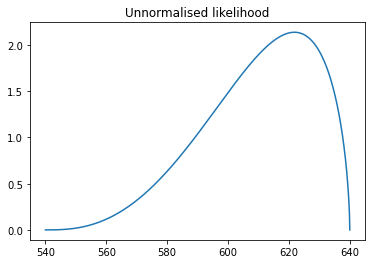

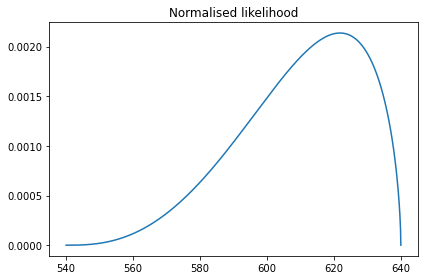

In [78]:
#Calculatoing likelhood
fig, ax = plt.subplots()
grid = np.linspace(0,1,1001)
grid_plot = []
like = []
count = 0
for i in grid:

    val = calculate_beta(i,3.7,1.6)

    like.append(val)

    count+=val

    grid_plot.append((i*100)+540)

like_norm = np.asarray(like)/count
ax.plot(grid_plot, like);
ax.set_title("Unnormalised likelihood")


fig, ax = plt.subplots()
ax.plot(grid_plot, like_norm);
print(f"Unnormalised areas = {round(count/count)}")
ax.set_title("Normalised likelihood")


fig.tight_layout()

Here the likelhoods have been created, as you can see it vaguely resembles the energy plot of the first ionsations that was shown above. A normalised version has also been created however this just looks the same but with the sizes scaled down so that the area under the curve is equal to 1.

Now it is time to make the postierior. Since we don't know much about how the data is distributed apart from the mean and std, we will use a sime gaussian to compute the distribution.  We will use the mean and std that were created above inside the gaussain function.

Area of non normalised prior = 8.9
Area of normalised prior = 1.0


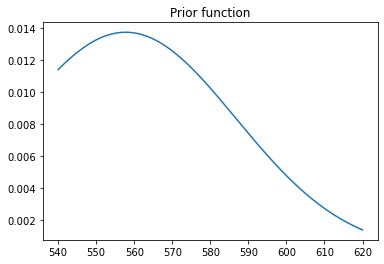

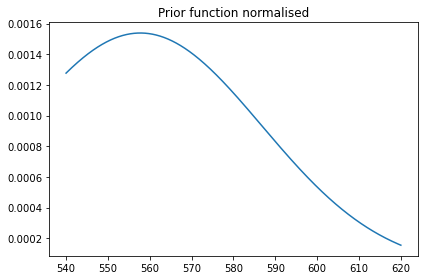

In [79]:
#calc prior
grid_prior = np.linspace(540,620,1001)
prior = []
count = 0

for i in grid_prior:
    val = compute_gaussian(i,mean,std)
    prior.append(val)
    count+=val

prior_norm = np.asarray(prior)/count
fig, ax = plt.subplots()
ax.plot(grid_prior, prior);
print(f"Area of non normalised prior = {round(count,1)}")
ax.set_title("Prior function")


fig, ax = plt.subplots()
ax.plot(grid_prior, prior_norm,)
print(f"Area of normalised prior = {round(count/count,1)}")

ax.set_title("Prior function normalised")
fig.tight_layout()


We can see that the prior function has a maximum value over the mean, and a nice tail towards the low 600s which is where the data was leading too and had the one "outlier" of Yb.

Now we have the likliness andn the prior calculated and normalised, we are able to combine them to get a value for our posterior.

NB factor = 0.0006810068305020671


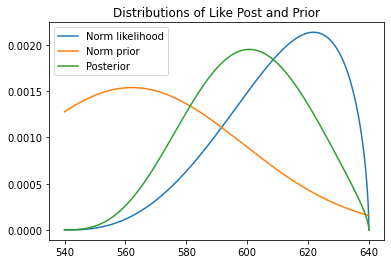

In [82]:
#norm_factor == norm_prior*norm_likelihood
norm_factor = np.dot(prior_norm,like_norm)
print(f"NB factor = {norm_factor}")

#calc post
posterior = []
grid_post = np.linspace(540,620,1001)

for i in range(len(grid_post)):

    posterior.append(prior_norm[i] * like_norm[i]/norm_factor)

#plot of all the normed prior post and like
fig,ax = plt.subplots()
ax.plot(grid_plot, like_norm, label = 'Norm likelihood')
ax.plot(grid_plot, prior_norm, label = 'Norm prior')
ax.plot(grid_plot, posterior, label = 'Posterior')
ax.set_title("Distributions of Like Post and Prior")
ax.legend();


We can then use this newly calculated positerior to find a new mean by finding the maximum value of the distribution.

In [87]:
new_mean = grid_plot[np.where(np.asarray(posterior)==np.asarray(posterior).max())[0][0]]
print(f"New mean = {new_mean}")
print(f"Old mean = {mean}")

New mean = 600.7
Old mean = 557.7399999999999


Using Bayesian we have been able to compute a new mean using the Beta and gaussian distrubitions for the likelihood and prior.

The newly calculated mean is 600.7. The mean calcualted from the dataset was 556.7.